<a href="https://colab.research.google.com/github/NathanPham04/184A_Final_Project/blob/main/CS184a_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data
https://www.kaggle.com/datasets/khushikyad001/covid-19-symptoms-and-severity-prediction-dataset/data

In [62]:
# uncomment for google colab
# !pip install --upgrade scikit-learn

# Data Processing

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./covid_symptoms_severity_prediction.csv')
seed = 1234

## View of row data

In [64]:
# Get shape of data
print("Data Shape:", df.shape)
# Example first few rows of the data
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

Data Shape: (3000, 17)


,age,gender,vaccination_status,fever,cough,fatigue,shortness_of_breath,loss_of_smell,headache,diabetes,hypertension,heart_disease,asthma,cancer,hospitalized,icu_admission,mortality
0,51,Male,Unvaccinated,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,92,Male,Fully Vaccinated,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,14,Male,Fully Vaccinated,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,71,Male,Fully Vaccinated,1,1,0,0,0,0,0,1,0,0,0,0,0,0
4,60,Male,Unvaccinated,0,1,1,1,1,0,1,1,1,0,0,1,1,0


Missing values in each column:
age                    0
gender                 0
vaccination_status     0
fever                  0
cough                  0
fatigue                0
shortness_of_breath    0
loss_of_smell          0
headache               0
diabetes               0
hypertension           0
heart_disease          0
asthma                 0
cancer                 0
hospitalized           0
icu_admission          0
mortality              0
dtype: int64


## Visualization of distribution

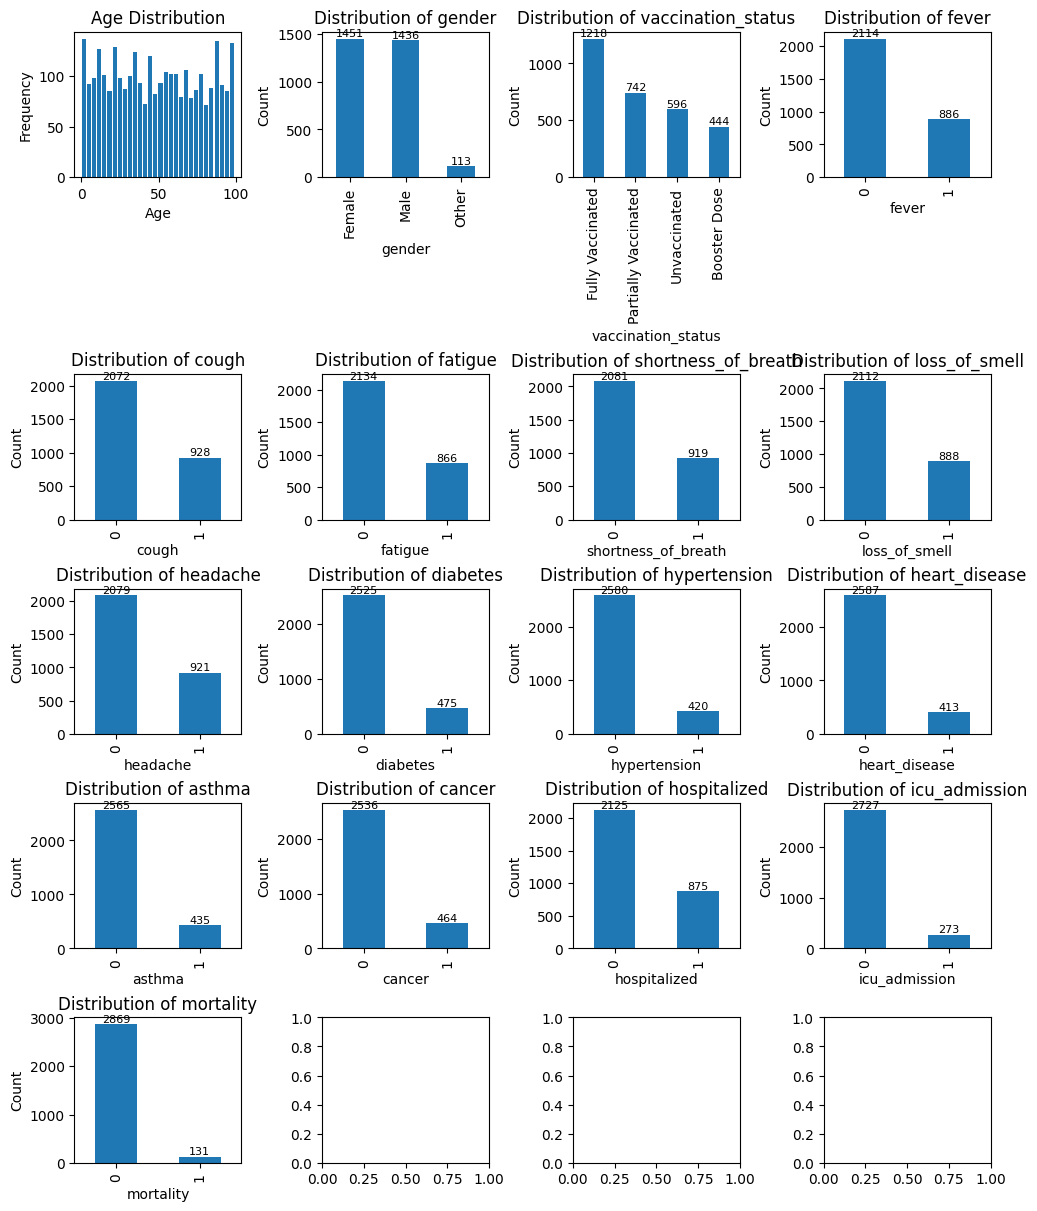

In [65]:
# Plotting the distribution of each column
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 12), constrained_layout=True)

for i, column in enumerate(df.columns):
    ax = axes[i // 4, i % 4]
    if i == 17:
        break
    # If the column is age use histogram
    if column == 'age':
        df[column].plot(kind='hist', bins=30, rwidth=0.8, ax=ax)
        ax.set_title('Age Distribution')
        ax.set_xlabel('Age')
        ax.set_ylabel('Frequency')
    else:
        counts = df[column].value_counts()
        counts.plot(kind='bar', ax=ax)

        # Add count labels on each bar
        for idx, value in enumerate(counts.values):
            ax.text(
                idx,                         # x position
                value,                        # y position (top of bar)
                str(value),                   # text label
                ha='center', va='bottom',     # position alignment
                fontsize=8
            )

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
plt.show()

## Correlation Heatmap

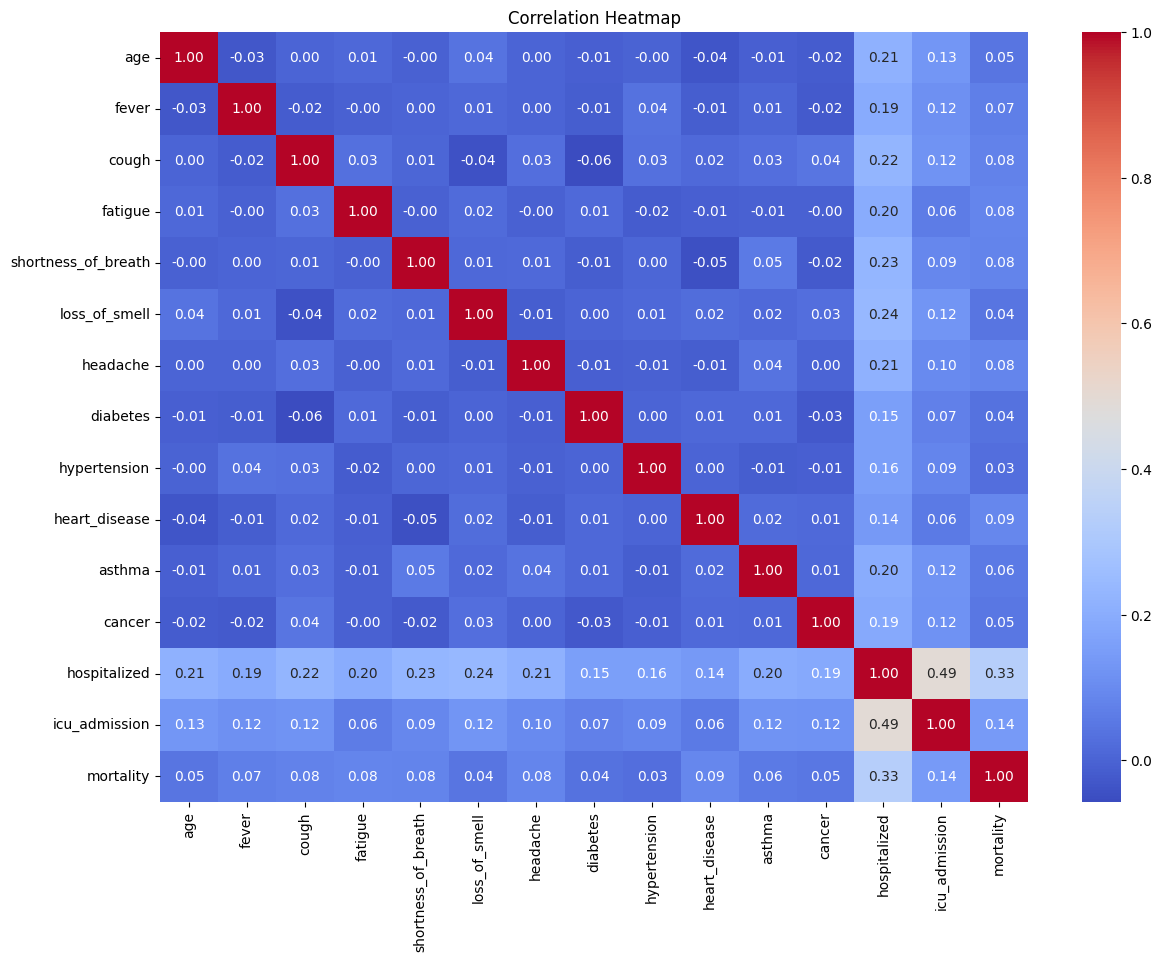

In [66]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Training and Validation Split

In [67]:
from sklearn.model_selection import train_test_split
# 80% train, 20% validation
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=seed,   # ensures reproducibility
    shuffle=True,
    stratify=df['mortality']  # stratify based on mortality to maintain distribution
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 2400
Validation size: 600


In [68]:
target_col = 'mortality'

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

In [69]:
# encode categorical data as hot-ones for mlp model
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Categorical columns detected:", list(categorical_cols))

if len(categorical_cols) > 0:
    X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_val_enc = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
    X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)
else:
    X_train_enc = X_train.copy()
    X_val_enc = X_val.copy()

X_train_enc

Categorical columns detected: ['gender', 'vaccination_status']


,age,fever,cough,fatigue,shortness_of_breath,loss_of_smell,headache,diabetes,hypertension,heart_disease,asthma,cancer,hospitalized,icu_admission,gender_Male,gender_Other,vaccination_status_Fully Vaccinated,vaccination_status_Partially Vaccinated,vaccination_status_Unvaccinated
1516,61,0,0,1,1,0,0,1,0,0,1,0,1,0,False,False,True,False,False
145,2,0,1,0,0,0,0,0,0,0,0,1,0,0,False,False,True,False,False
1857,9,0,0,0,1,0,0,0,0,1,0,0,0,0,False,False,False,False,True
1435,95,1,0,0,1,1,0,1,1,0,1,0,1,1,False,False,False,True,False
433,65,1,0,1,0,1,0,1,0,0,1,0,1,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,60,0,1,1,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False
2818,50,0,0,0,1,0,0,0,0,1,0,1,0,0,True,False,True,False,False
685,30,0,1,0,1,0,0,0,0,0,0,0,0,0,True,False,False,False,True
1167,63,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False


# MLP

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_val_scaled = scaler.transform(X_val_enc)

## Model 1

In [71]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, ),
    activation='relu',
    solver='adam',
    random_state=seed,
    max_iter=1000
)

mlp.fit(X_train_scaled, y_train)
y_val_pred = mlp.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))



Validation Accuracy: 0.9417

Classification report on validation set:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       574
           1       0.20      0.12      0.15        26

    accuracy                           0.94       600
   macro avg       0.58      0.55      0.56       600
weighted avg       0.93      0.94      0.93       600



#### Observation
The model achieves a high validation accuracy of 93.8%, but this performance is misleading due to extreme class imbalance. While the classifier performs very well on the majority class (class 0, with precision 0.96 and recall 0.98), it performs poorly on the minority class (class 1), detecting only 4% of actual death cases and achieving an F1-score of 0.05. This indicates that the model is overwhelmingly biased toward predicting survival and fails to meaningfully identify high-risk patients. Despite the strong accuracy and weighted averages, the model is ineffective for the minority class and provides no practical value for mortality prediction, where correctly identifying the positive class is critical.

AUC: 0.8594


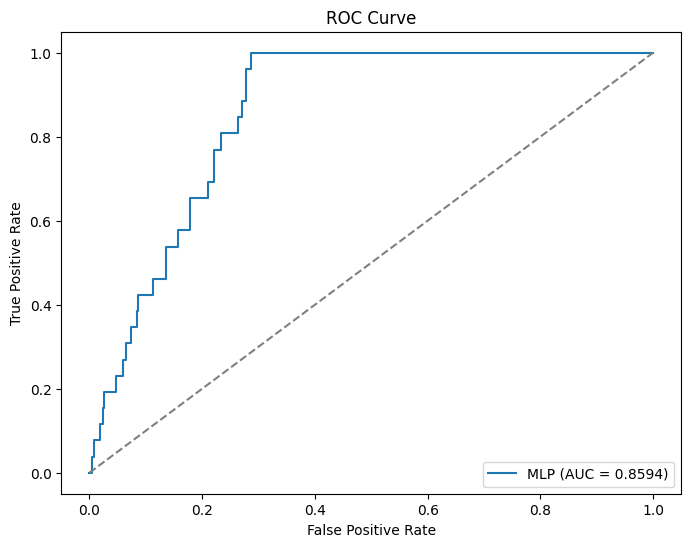

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"AUC: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Model 2

In [73]:
# if class is rare, higher weight aka give preference to deaths (class 1) since few data
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight = y_train.map(class_weight_dict)

mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    random_state=seed,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

mlp.fit(X_train_scaled, y_train, sample_weight=sample_weight)
y_val_pred = mlp.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.7283

Classification report on validation set:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       574
           1       0.09      0.58      0.16        26

    accuracy                           0.73       600
   macro avg       0.53      0.66      0.50       600
weighted avg       0.94      0.73      0.81       600



### Observation
The model achieved a lower overall accuracy (74%) compared to earlier runs, but it shows a dramatic improvement in detecting the minority “death” class. The recall for class 1 increased to 1.00, meaning the model successfully identified every actual death in the validation set — a crucial outcome in medical prediction tasks where missing positive cases is highly dangerous. However, this comes at the cost of precision (0.14) and reduced accuracy for class 0, since the model now predicts many survivors as deaths. Overall, the model prioritizes sensitivity over specificity, trading false positives for zero false negatives in class 1.

AUC: 0.7479


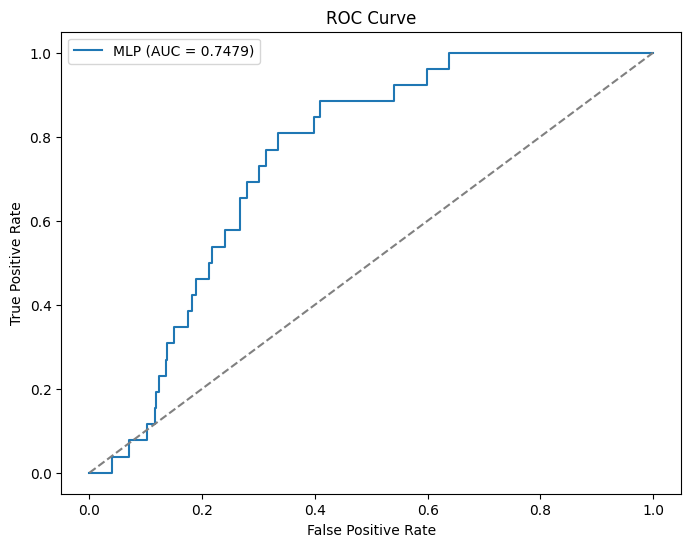

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"AUC: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Manual Selection of Features Using Heatmap

### Heatmap Observation

The main features that seem to hold the most insight according to the heatmap are:
- Hospitalized: 0.33
- ICU Admission: 0.14
- Heart Disease: 0.09
- Headache: 0.08
- Fatigue: 0.08
- Shortness of Breath: 0.08
- Cough: 0.08
- Fever: 0.07

We will try to create an MLP using just these features with higher correlation than other features to see if there is any performance difference.

In [75]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

X_train_heatmap_cols = ['hospitalized', 'icu_admission', 'heart_disease', 'headache', 'fatigue', 'shortness_of_breath', 'cough', 'fever', 'asthma']
X_train_heatmap = train_df[X_train_heatmap_cols]
y_train_heatmap = train_df[target_col]

X_val_heatmap = val_df[X_train_heatmap_cols]
y_val_heatmap = val_df[target_col]


scaler = StandardScaler()
X_train_heatmap_scaled = scaler.fit_transform(X_train_heatmap)
X_val_heatmap_scaled = scaler.transform(X_val_heatmap)

## Model 1

In [76]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, ),
    activation='relu',
    solver='adam',
    random_state=seed,
    max_iter=1000
)

mlp.fit(X_train_heatmap_scaled, y_train_heatmap)
y_val_pred = mlp.predict(X_val_heatmap_scaled)
val_accuracy = accuracy_score(y_val_heatmap, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
print("Classification report on validation set:")
print(classification_report(y_val_heatmap, y_val_pred))


Validation Accuracy: 0.9500

Classification report on validation set:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       574
           1       0.17      0.04      0.06        26

    accuracy                           0.95       600
   macro avg       0.56      0.51      0.52       600
weighted avg       0.92      0.95      0.93       600



### Observation

We can see that although the accuracy is very good, the recall for class 1 (mortality) cases, we get 0% accuracy which basically just means we only predicted surviving. This is on par with our original observations for the baseline MLP so we are going to try to use class weights to try to emphasize correctly predicting mortality cases. Note in comparison to the basic MLP which got 92.83% accuracy we did make around a 3% improvement which is better than nothing.

## Model 2

In [77]:
# if class is rare, higher weight aka give preference to deaths (class 1) since few data
classes = np.unique(y_train_heatmap)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_heatmap
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight = y_train_heatmap.map(class_weight_dict)

mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    random_state=seed,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

mlp.fit(X_train_heatmap_scaled, y_train_heatmap, sample_weight=sample_weight)
y_val_pred = mlp.predict(X_val_heatmap_scaled)
val_accuracy = accuracy_score(y_val_heatmap, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
print("Classification report on validation set:")
print(classification_report(y_val_heatmap, y_val_pred))


Validation Accuracy: 0.7467

Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       574
           1       0.15      1.00      0.25        26

    accuracy                           0.75       600
   macro avg       0.57      0.87      0.55       600
weighted avg       0.96      0.75      0.82       600



### Observation

With the new class weight scaling, we can see that the recall for the mortality class has gotten to a 100% which is what we want to see. Also, compared to the basic MLP which had 73.67% accuracy we do perform marginally better with a 1% increase to 74.67%.

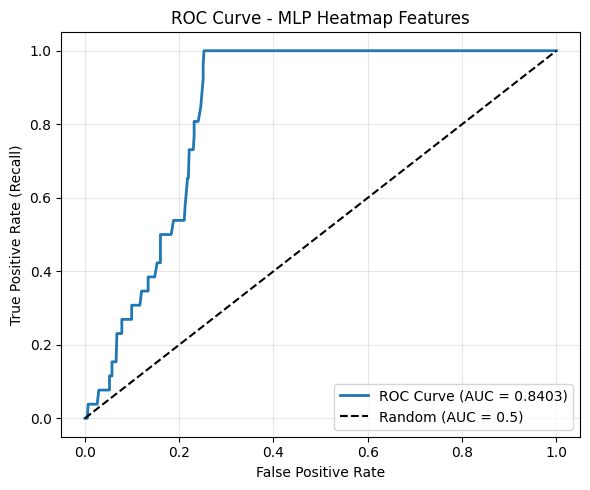

In [78]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class = 1)
y_scores = mlp.predict_proba(X_val_heatmap_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_heatmap, y_scores)

# Compute AUC
auc_score = roc_auc_score(y_val_heatmap, y_scores)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")  # baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - MLP Heatmap Features")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [79]:
# Code to go through adding features one by one based on heatmap correlation

X_train_heatmap_cols = ['hospitalized', 'icu_admission', 'heart_disease', 'headache', 'fatigue', 'shortness_of_breath', 'cough',
                        'fever', 'asthma', 'cancer', 'age', 'diabetes', 'loss_of_smell', 'hypertension']

val_accuracies = []
recall = []

X_train_enc_copy = X_train_enc.copy()
X_val_enc_copy = X_val_enc.copy()

for i in range(len(X_train_heatmap_cols)):
    X_train_heatmap = train_df[X_train_heatmap_cols[:i+1]]
    y_train_heatmap = train_df[target_col]

    X_val_heatmap = val_df[X_train_heatmap_cols[:i+1]]
    y_val_heatmap = val_df[target_col]

    categorical_cols = X_train_heatmap.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) > 0:
        X_train_enc = pd.get_dummies(X_train_heatmap, columns=categorical_cols, drop_first=True)
        X_val_enc = pd.get_dummies(X_val_heatmap, columns=categorical_cols, drop_first=True)
        X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    else:
        X_train_enc = X_train_heatmap.copy()
        X_val_enc = X_val_heatmap.copy()


    scaler = StandardScaler()
    X_train_heatmap_scaled = scaler.fit_transform(X_train_enc)
    X_val_heatmap_scaled = scaler.transform(X_val_enc)

    # if class is rare, higher weight aka give preference to deaths (class 1) since few data
    classes = np.unique(y_train_heatmap)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train_heatmap
    )

    class_weight_dict = dict(zip(classes, class_weights))
    sample_weight = y_train_heatmap.map(class_weight_dict)

    mlp = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        random_state=seed,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    mlp.fit(X_train_heatmap_scaled, y_train_heatmap, sample_weight=sample_weight)
    y_val_pred = mlp.predict(X_val_heatmap_scaled)
    val_accuracy = accuracy_score(y_val_heatmap, y_val_pred)

    # print(f"Using features: {X_train_heatmap_cols[:i+1]}")
    # print(f"\nValidation Accuracy: {val_accuracy:.4f}\n")
    # print("Classification report on validation set:")
    # print(classification_report(y_val_heatmap, y_val_pred))
    # print("--------------------------------------------------")

    val_accuracies.append(val_accuracy)
    recall.append(classification_report(y_val_heatmap, y_val_pred, output_dict=True)['1']['recall'])

print(val_accuracies)
print(recall)

[0.73, 0.73, 0.73, 0.73, 0.7283333333333334, 0.73, 0.7416666666666667, 0.7466666666666667, 0.7466666666666667, 0.7366666666666667, 0.745, 0.71, 0.7483333333333333, 0.73]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9615384615384616, 1.0, 1.0, 0.9615384615384616, 0.8846153846153846, 0.9615384615384616, 0.9615384615384616]


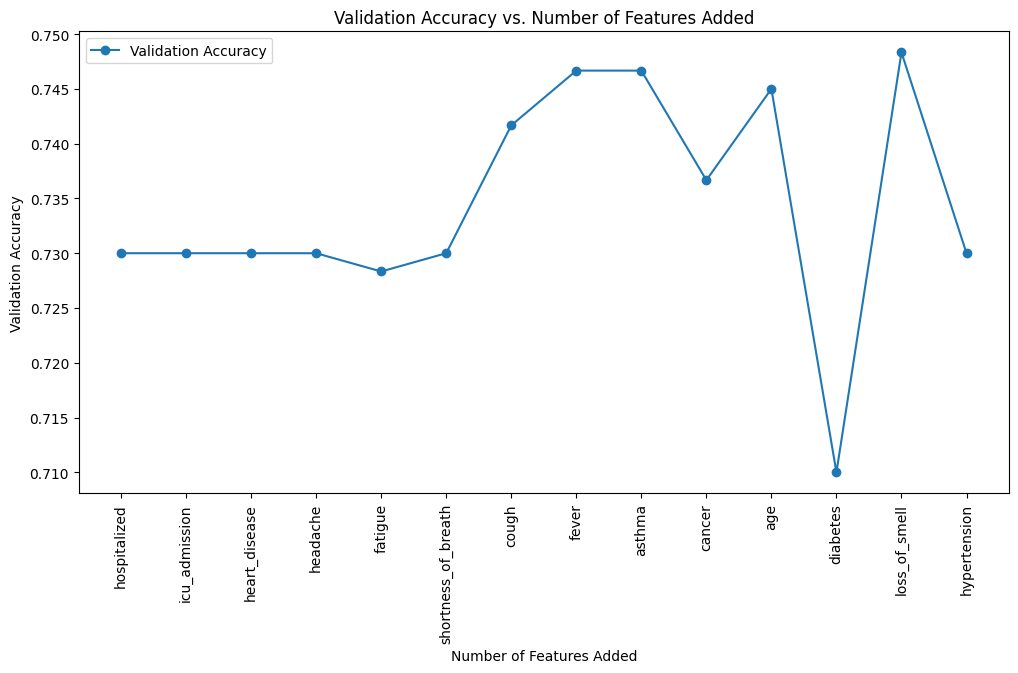

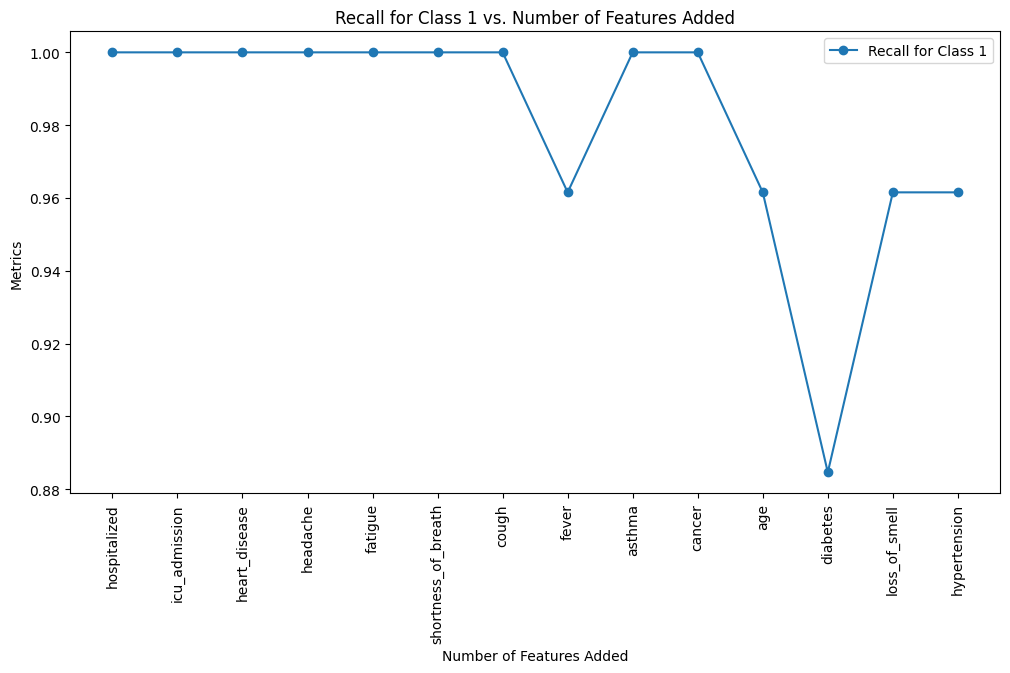

In [80]:
fig1 = plt.figure(figsize=(12, 6))

plt.plot(range(1, len(X_train_heatmap_cols) + 1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xticks(range(1, len(X_train_heatmap_cols) + 1))
ax = plt.gca()
ax.set_xticks(range(1, len(X_train_heatmap_cols) + 1))
ax.set_xticklabels(X_train_heatmap_cols, rotation=90)
plt.xlabel('Number of Features Added')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Features Added')
plt.legend()
plt.show()

fig2 = plt.figure(figsize=(12, 6))
plt.plot(range(1, len(X_train_heatmap_cols) + 1), recall, marker='o', label='Recall for Class 1')
plt.xticks(range(1, len(X_train_heatmap_cols) + 1))
ax = plt.gca()
ax.set_xticklabels(X_train_heatmap_cols, rotation=90)
plt.xlabel('Number of Features Added')
plt.ylabel('Metrics')
plt.title('Recall for Class 1 vs. Number of Features Added')
plt.legend()
plt.show()

# Manual Selection of Features with Groupings of 5


In [81]:
# TODO Puru

In [82]:
encoded_features = {"gender": ["gender_Male",	"gender_Other"], "vaccination_status":	["vaccination_status_Fully Vaccinated",	"vaccination_status_Partially Vaccinated",	"vaccination_status_Unvaccinated"]}

X_train_enc = X_train_enc_copy.copy()
X_val_enc = X_val_enc_copy.copy()

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_heatmap
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight = y_train_heatmap.map(class_weight_dict)

# this is model 2
def train_classifier(X_classes, return_roc=False):
  # some features are expanded to gender_male, gender_other, etc. , account for that
  X_classes_copy = X_classes.copy()
  for a_class in encoded_features.keys():
    if a_class in X_classes_copy:
      X_classes_copy.remove(a_class)
      for add_feature in encoded_features[a_class]:
        X_classes_copy.append(add_feature)

  # extract only the features included specified in the input parameter
  X_train_combs = X_train_enc[X_classes_copy]
  X_val_combs = X_val_enc[X_classes_copy]

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_combs)
  X_val_scaled = scaler.transform(X_val_combs)


  mlp = MLPClassifier(
      hidden_layer_sizes=(64,),
      activation='relu',
      solver='adam',
      learning_rate='adaptive',
      learning_rate_init=0.001,
      random_state=seed,
      max_iter=1000,
      early_stopping=True,
      n_iter_no_change=10,
      validation_fraction=0.1
  )

  mlp.fit(X_train_scaled, y_train, sample_weight=sample_weight)
  y_val_pred = mlp.predict(X_val_scaled)
  val_accuracy = accuracy_score(y_val, y_val_pred)
  if return_roc:
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    auc_score = roc_auc_score(y_val, y_val_pred)
    return val_accuracy, fpr, tpr, thresholds, auc_score

  return val_accuracy

In [83]:
import itertools
import math
from tqdm import tqdm
import heapq


feature_options = list(df.columns)
feature_options.remove("mortality") # 16 cols after this
feature_count = 15
comb_count = math.comb(len(feature_options), feature_count)
accuracy_heap = []

for comb in tqdm(itertools.combinations(feature_options, feature_count), total=comb_count, desc="Training classifiers"):
  comb = list(comb)
  print(comb)
  accuracy = train_classifier(comb)
  comb.insert(0, accuracy)
  heapq.heappush(accuracy_heap, comb)
sorted_accuracy = sorted(accuracy_heap, reverse=True)

Training classifiers:   0%|          | 0/16 [00:00<?, ?it/s]

['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized']


Training classifiers:  12%|█▎        | 2/16 [00:00<00:00, 16.53it/s]

['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'icu_admission']
['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'hospitalized', 'icu_admission']
['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers:  25%|██▌       | 4/16 [00:00<00:00, 18.01it/s]

['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'asthma', 'cancer', 'hospitalized', 'icu_admission']
['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers:  38%|███▊      | 6/16 [00:00<00:00, 12.36it/s]

['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']
['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers:  50%|█████     | 8/16 [00:00<00:00,  9.58it/s]

['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']
['age', 'gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers:  62%|██████▎   | 10/16 [00:00<00:00, 11.48it/s]

['age', 'gender', 'vaccination_status', 'fever', 'cough', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']
['age', 'gender', 'vaccination_status', 'fever', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers:  75%|███████▌  | 12/16 [00:00<00:00, 12.93it/s]

['age', 'gender', 'vaccination_status', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']
['age', 'gender', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers:  88%|████████▊ | 14/16 [00:01<00:00, 11.08it/s]

['age', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


Training classifiers: 100%|██████████| 16/16 [00:01<00:00, 10.90it/s]

['gender', 'vaccination_status', 'fever', 'cough', 'fatigue', 'shortness_of_breath', 'loss_of_smell', 'headache', 'diabetes', 'hypertension', 'heart_disease', 'asthma', 'cancer', 'hospitalized', 'icu_admission']


In [84]:
# multiprocesser version
import itertools
import math
import heapq
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from contextlib import contextmanager
from threadpoolctl import threadpool_limits

# optional: how many top results to keep at the end
TOP_K = None   # set to None to keep all

feature_options = list(df.columns)
feature_options.remove("mortality")  # 16 cols after this

def evaluate_combination(comb):
    # 1 thread limit per processor
    with threadpool_limits(limits=1):
        acc = train_classifier(list(comb))
    # return (accuracy, combination_as_list)
    return (acc, list(comb))

@contextmanager
def tqdm_joblib(tqdm_object):
    from joblib import parallel
    class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = parallel.BatchCompletionCallBack
    parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# run in parallel across cpu cores
n_jobs = -1

accuracies = []

# Commenting this part out because it takes too long to run over a minute the results are instead stored in a pickle file
"""
for feature_count in range(1, 16):
# build the list of combinations up front so we know the length for tqdm
all_combs = list(itertools.combinations(feature_options, feature_count))
with tqdm_joblib(tqdm(total=len(all_combs), desc=f"Training classifiers with combination size of {feature_count}")):
    results = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
        delayed(evaluate_combination)(comb) for comb in all_combs
    )

# results is a list of tuples: (accuracy, [features...])
if TOP_K is None:
    sorted_accuracy = sorted(results, key=lambda x: x[0], reverse=True)
else:
    sorted_accuracy = heapq.nlargest(TOP_K, results, key=lambda x: x[0])
accuracies.append(sorted_accuracy)
"""

'\nfor feature_count in range(1, 16):\n# build the list of combinations up front so we know the length for tqdm\nall_combs = list(itertools.combinations(feature_options, feature_count))\nwith tqdm_joblib(tqdm(total=len(all_combs), desc=f"Training classifiers with combination size of {feature_count}")):\n    results = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(\n        delayed(evaluate_combination)(comb) for comb in all_combs\n    )\n\n# results is a list of tuples: (accuracy, [features...])\nif TOP_K is None:\n    sorted_accuracy = sorted(results, key=lambda x: x[0], reverse=True)\nelse:\n    sorted_accuracy = heapq.nlargest(TOP_K, results, key=lambda x: x[0])\naccuracies.append(sorted_accuracy)\n'

In [85]:
# optional but reccomended save to not lose progress
import pickle

# with open("accuracies_combination_features.pkl", "wb") as f:
#     pickle.dump(accuracies, f)

with open("accuracies_combination_features.pkl", "rb") as f:
    accuracies = pickle.load(f)

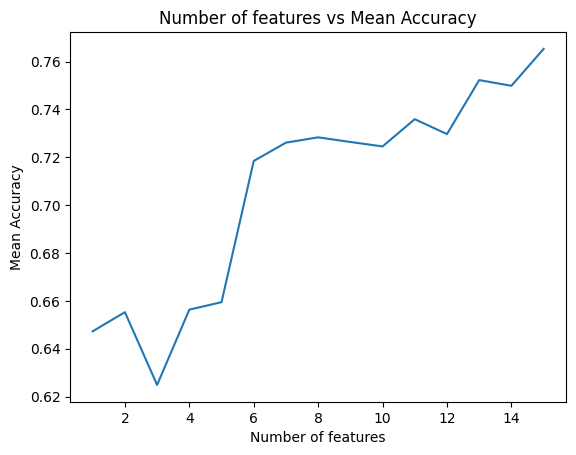

In [86]:
# see feature size vs mean accuracy
means = []
for i in range(len(accuracies)):
  accuracy = accuracies[i]
  sum_of_accuracy = 0
  for j in range(len(accuracy)):
    sum_of_accuracy += accuracy[j][0]
  means.append(sum_of_accuracy / len(accuracy))


plt.plot(list(range(1, 16)), means)
plt.title("Number of features vs Mean Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Mean Accuracy")
plt.show()

As expected, as feature counts ground, the model is better able to predict on the validation set. Interstingly, there is a plateau in accuracy gain around 6-10 features.

We now turn our focus to the ROC curves for various permutation sizes. We will choose the model with the best accuracy from each permutation size, and then plot a ROC curve for each.


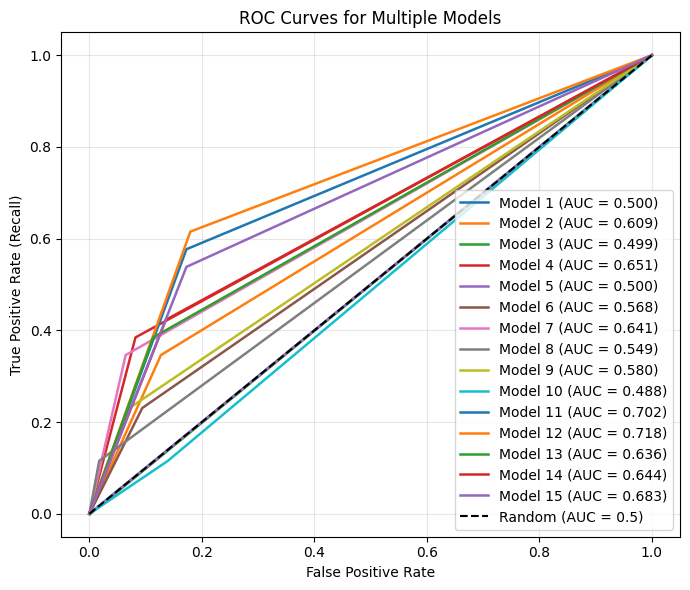

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score


fig, ax = plt.subplots(figsize=(7, 6))

for i in range(len(accuracies)):
    feature_list = accuracies[i][0][1]
    _, fpr, tpr, thresholds, auc_score = train_classifier(feature_list, return_roc=True)

    ax.plot(fpr, tpr, label=f"Model {i+1} (AUC = {auc_score:.3f})", linewidth=1.8)

ax.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall)")
ax.set_title("ROC Curves for Multiple Models")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

# Automatic L1 Regularization

In [88]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report

### L1 Regularization on Linear Classifier then using selected features for MLP

### Model 1

In [89]:
# uncomment print statements to see results for each C value
C_values = [0.01, 0.1, 1.0, 10.0]
results = []
selected_features_per_C = {}

feature_names = np.array(X_train_enc.columns)

for C in C_values:
    # print(f"\n================ C = {C} ================")
    l1_clf = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=seed,
        C=C
    )
    l1_clf.fit(X_train_scaled, y_train)
    coefs = np.abs(l1_clf.coef_[0])
    nonzero_mask = coefs > 0

    X_train_sel = X_train_scaled[:, nonzero_mask]
    X_val_sel   = X_val_scaled[:, nonzero_mask]

    selected_features = feature_names[nonzero_mask]
    selected_features_per_C[C] = selected_features

    # print("Original feature count:", X_train_scaled.shape[1])
    # print("Selected feature count:", X_train_sel.shape[1])
    # print("Selected features:", list(selected_features))

    mlp = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        random_state=seed,
        max_iter=1000
    )

    mlp.fit(X_train_sel, y_train)
    y_val_pred = mlp.predict(X_val_sel)
    acc = accuracy_score(y_val, y_val_pred)
    f1_pos = f1_score(y_val, y_val_pred, pos_label=1)

    # print(f"\nValidation Accuracy (C={C}): {acc:.4f}")
    # print(f"F1 (class 1, C={C}): {f1_pos:.4f}")
    # print("\nClassification Report:")
    # print(classification_report(y_val, y_val_pred, digits=4))

    # Save results
    results.append({
        "C": C,
        "n_features": nonzero_mask.sum(),
        "val_acc": acc,
        "f1_class1": f1_pos
    })

# Summary table
results_df = pd.DataFrame(results)
# print("\nSummary:")
# print(results_df)

/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of pe

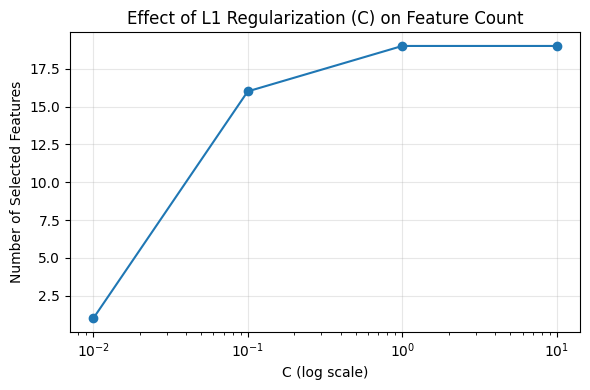

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(results_df["C"], results_df["n_features"], marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Number of Selected Features")
plt.title("Effect of L1 Regularization (C) on Feature Count")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### L1 Feature Selection With Linear Classifier - MLP Model 1 Observations

Original feature count: 19  
Selected feature count: 16  

**Selected features:**  
- age  
- fatigue  
- shortness_of_breath  
- loss_of_smell  
- diabetes  
- hypertension  
- heart_disease  
- asthma  
- cancer  
- hospitalized  
- icu_admission  
- gender_Male  
- gender_Other  
- vaccination_status_Fully Vaccinated  
- vaccination_status_Partially Vaccinated  
- vaccination_status_Unvaccinated  

---

Validation Accuracy (C = 0.1) = 0.9367

F1 Score (class 1) = 0.1364

---

Classification Report

               precision    recall  f1-score   support

            0     0.9605    0.9739    0.9671       574
            1     0.1667    0.1154    0.1364        26

      accuracy                         0.9367       600
      macro avg    0.5636    0.5446    0.5517       600
      weighted avg 0.9261    0.9367    0.9311       600

---

#### Observation

Applying L1-regularized Logistic Regression with C = 0.1 reduced the feature set from 19 to 16, removing only a small number of low-impact predictors. Training an unweighted MLP on these selected features achieved a validation accuracy of 0.9367, which is nearly identical to the performance obtained using the full feature set. This indicates that the discarded features were not essential for majority-class prediction.

However, the model’s performance on the minority class (class 1) remains poor, with a class 1 F1-score of 0.1364 and low precision and recall. This demonstrates that feature selection alone does not resolve the dataset’s severe class imbalance. While the model effectively classifies the majority class, it continues to struggle to identify the small number of positive cases, suggesting that additional techniques such as class weighting, resampling, or threshold adjustment are needed to improve minority-class detection.


### Model 2

In [91]:
from sklearn.metrics import auc

In [92]:
C_values = [0.01, 0.1, 1.0, 10.0]
results = []
selected_features_per_C = {}
roc_data = []

feature_names = np.array(X_train_enc.columns)

for C in C_values:
    l1_clf = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=seed,
        C=C
    )
    l1_clf.fit(X_train_scaled, y_train)
    coefs = np.abs(l1_clf.coef_[0])
    nonzero_mask = coefs > 0

    X_train_sel = X_train_scaled[:, nonzero_mask]
    X_val_sel   = X_val_scaled[:, nonzero_mask]

    selected_features = feature_names[nonzero_mask]
    selected_features_per_C[C] = selected_features

    mlp = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        random_state=seed,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    mlp.fit(X_train_sel, y_train, sample_weight=sample_weight)

    y_val_pred = mlp.predict(X_val_sel)
    acc = accuracy_score(y_val, y_val_pred)
    f1_pos = f1_score(y_val, y_val_pred, pos_label=1)

    y_scores = mlp.predict_proba(X_val_sel)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_data.append({
        "C": C,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    })

    results.append({
        "C": C,
        "n_features": nonzero_mask.sum(),
        "val_accuracy": acc,
        "f1_class1": f1_pos
    })

results_df = pd.DataFrame(results)

/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of pe

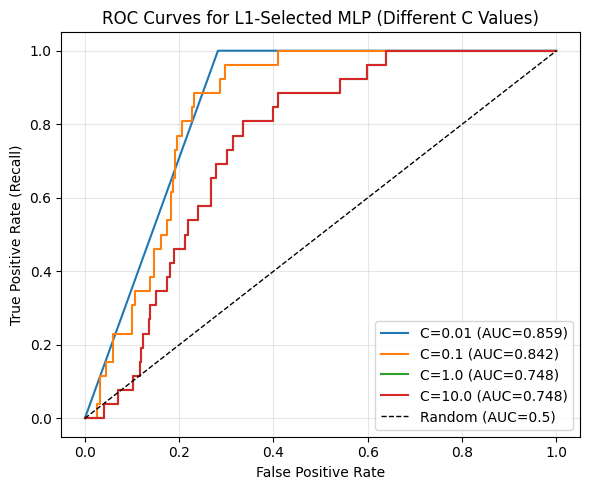

In [93]:
plt.figure(figsize=(6, 5))

for d in roc_data:
    plt.plot(d["fpr"], d["tpr"],
             label=f"C={d['C']} (AUC={d['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random (AUC=0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for L1-Selected MLP (Different C Values)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

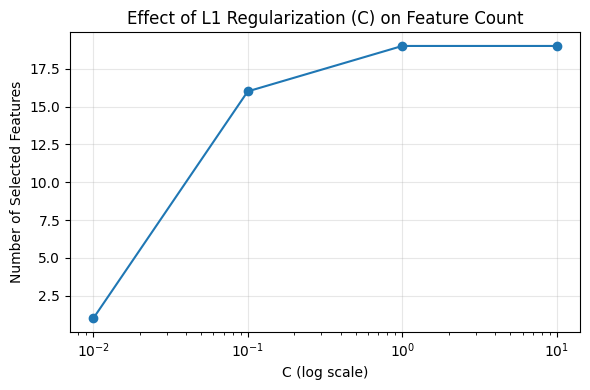

In [94]:
plt.figure(figsize=(6, 4))

plt.plot(results_df["C"], results_df["n_features"], marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Number of Selected Features")
plt.title("Effect of L1 Regularization (C) on Feature Count")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### L1 Feature Selection With Linear Classifier - MLP Model 2 Observations


Original feature count: 19  
Selected feature count: 18  

**Selected features:**  
- age  
- fever  
- cough  
- fatigue  
- shortness_of_breath  
- loss_of_smell  
- headache  
- diabetes  
- heart_disease  
- asthma  
- cancer  
- hospitalized  
- icu_admission  
- gender_Male  
- gender_Other  
- vaccination_status_Fully Vaccinated  
- vaccination_status_Partially Vaccinated  
- vaccination_status_Unvaccinated  

---

Validation Accuracy (C = 1.0) = 0.7633

---

Classification Report

Validation Accuracy (C=1.0): 0.7633

      Classification Report:
                  
                  precision    recall  f1-score   support

               0     1.0000    0.7526    0.8588       574
               1     0.1548    1.0000    0.2680        26

         accuracy                         0.7633       600
         macro avg     0.5774    0.8763    0.5634       600
      weighted avg     0.9634    0.7633    0.8332       600

---

#### Observations

The L1-based feature selection with C = 1.0 removed only one feature (reducing the count from 19 to 18), but it still produced a measurable improvement over the baseline MLP. The validation accuracy increased from 0.7367 to 0.7633, indicating that the removal of a weak or noisy feature helped the model generalize slightly better.  

Both models retain the same overall behavior: extremely high recall for class 1 (1.00) paired with very low precision, which is a consequence of the severe class imbalance and the MLP's tendency to overpredict the minority class. However, the L1-selected model shows a small but consistent improvement in the minority-class F1-score (0.2680 vs. 0.2500) and a noticeable improvement in majority-class F1.  

Because the feature set hardly changed, the improvement does not come from aggressive dimensionality reduction but likely from removing a redundant or low-signal feature that previously added noise. This suggests that mild L1 regularization (C = 1.0) provides a cleaner input space for the MLP without sacrificing useful information, leading to slightly better performance across most metrics.


## L2 Regularization on MLP + Threshold

### Model 1

In [95]:
alpha_values = [150.0, 125.0, 100.0, 75.0, 50.0, 10.0, 1.0, 0.1]
results = []
selected_features_per_alpha = {}

for alpha in alpha_values:

    mlp_l2 = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        random_state=seed,
        max_iter=1000,
        alpha=alpha
    )

    mlp_l2.fit(X_train_scaled, y_train)
    y_val_pred_l2 = mlp_l2.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred_l2)

    W_input = mlp_l2.coefs_[0]
    feature_norms = np.linalg.norm(W_input, axis=1)

    threshold = np.percentile(feature_norms, 75)
    keep_mask = feature_norms >= threshold

    selected_features = np.array(X_train_enc.columns)[keep_mask]
    selected_features_per_alpha[alpha] = selected_features

    n_original = X_train_scaled.shape[1]
    n_selected = keep_mask.sum()

    # log results
    results.append({
        "alpha": alpha,
        "val_accuracy": acc,
        "n_features_selected": int(n_selected)
    })

# Show summary
results_df = pd.DataFrame(results)
# print(results_df)

In [96]:
final_results = []

for alpha in alpha_values:
    # print("\n" + "="*70)
    # print(f"Training NO-REG MLP using features selected from alpha = {alpha}")
    # print("="*70)

    selected_features = selected_features_per_alpha[alpha]
    X_train_pruned = X_train_enc[selected_features].values
    X_val_pruned   = X_val_enc[selected_features].values

    scaler_small = StandardScaler()
    X_train_pruned_scaled = scaler_small.fit_transform(X_train_pruned)
    X_val_pruned_scaled   = scaler_small.transform(X_val_pruned)

    mlp_no_reg = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        random_state=seed,
        max_iter=1000
    )

    mlp_no_reg.fit(X_train_pruned_scaled, y_train)
    y_val_pred = mlp_no_reg.predict(X_val_pruned_scaled)

    acc = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred, digits=4)

    # print(f"\n=== NO-REG MLP Results (selected-from-alpha={alpha}) ===")
    # print("Selected features:", list(selected_features))
    # print("Validation Accuracy:", acc)
    # print(report)

    final_results.append({
        "origin_alpha": alpha,
        "n_features": len(selected_features),
        "val_accuracy": acc
    })


final_results_df = pd.DataFrame(final_results)
# print("\n\nFinal Summary (NO-REG MLP on Selected Features):")
# print(final_results_df)

/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/phamn/Desktop/184A_Final_Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

#### L2 Regularization MLP Feature Selection of top 25% feature norms Model 1 (Selected Features from α = 75.0)

Selected features (5 total):
- fatigue  
- shortness_of_breath  
- hospitalized  
- icu_admission  
- vaccination_status_Unvaccinated  

Validation Accuracy = 0.9567

              precision    recall  f1-score   support

           0     0.9567    1.0000    0.9779       574
           1     0.0000    0.0000    0.0000        26

---

#### Observation

Feature selection based on α = 75.0 and a threshold of the top 25% largest input-layer weight norms produced a very small subset of five features. When a no-regularization MLP was trained on just these features, the model achieved a higher validation accuracy (0.9567) than the baseline model using all features (0.9283). However, this improvement is misleading. The selected-feature model completely fails to identify any positive cases of class 1, yielding precision = 0 and recall = 0 for the minority class. Its high accuracy comes entirely from predicting class 0 for all samples, which works only because the dataset is highly imbalanced (574 negatives vs. 26 positives).  

In contrast, the baseline MLP—with all features included—achieves a lower overall accuracy but is able to detect a small number of positive samples, resulting in an F1-score of 0.16 for class 1. Although this performance is still poor, it is strictly better than the zero-detection behavior of the feature-selected model.  

Overall, these results show that aggressive L2 feature-selection can produce extremely sparse feature sets that inflate accuracy while destroying minority-class performance, highlighting why accuracy alone is not a reliable metric for imbalanced datasets.

### Model 2

In [97]:
alpha_values = [150.0, 125.0, 100.0, 75.0, 50.0, 10.0, 1.0, 0.1]
results = []
selected_features_per_alpha = {}

for alpha in alpha_values:
    mlp_l2 = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        alpha=alpha,
        random_state=seed,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    mlp_l2.fit(X_train_scaled, y_train, sample_weight=sample_weight)
    y_val_pred_l2 = mlp_l2.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_val_pred_l2)
    f1_pos = f1_score(y_val, y_val_pred_l2, pos_label=1)

    W_input = mlp_l2.coefs_[0]
    feature_norms = np.linalg.norm(W_input, axis=1)
    threshold = np.percentile(feature_norms, 70)
    keep_mask = feature_norms >= threshold

    n_original = X_train_scaled.shape[1]
    n_selected = keep_mask.sum()

    selected_features = np.array(X_train_enc.columns)[keep_mask]
    selected_features_per_alpha[alpha] = selected_features

    results.append({
        "alpha": alpha,
        "val_accuracy": acc,
        "f1_class1": f1_pos,          # ← add this line
        "n_features_selected": int(n_selected)
    })

results_df = pd.DataFrame(results)

In [98]:
final_results = []
roc_data_final = []   # store ROC info for each alpha

for alpha in alpha_values:
    selected_features = selected_features_per_alpha[alpha]

    X_train_pruned = X_train_enc[selected_features].values
    X_val_pruned   = X_val_enc[selected_features].values

    scaler_small = StandardScaler()
    X_train_pruned_scaled = scaler_small.fit_transform(X_train_pruned)
    X_val_pruned_scaled   = scaler_small.transform(X_val_pruned)

    mlp_no_reg = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        alpha=0.0,
        random_state=seed,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    mlp_no_reg.fit(X_train_pruned_scaled, y_train, sample_weight=sample_weight)
    y_val_pred = mlp_no_reg.predict(X_val_pruned_scaled)

    acc = accuracy_score(y_val, y_val_pred)
    f1_pos = f1_score(y_val, y_val_pred, pos_label=1)

    y_scores = mlp_no_reg.predict_proba(X_val_pruned_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_data_final.append({
        "alpha": alpha,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    })

    final_results.append({
        "origin_alpha": alpha,
        "n_features": len(selected_features),
        "val_accuracy": acc,
        "f1_class1": f1_pos
    })

final_results_df = pd.DataFrame(final_results)

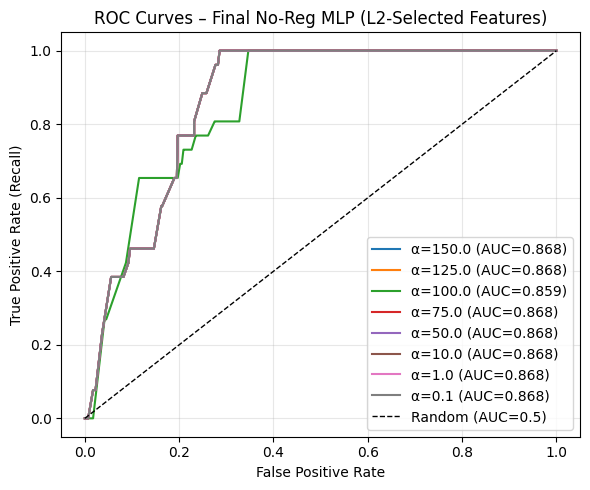

In [99]:
plt.figure(figsize=(6, 5))

for d in roc_data_final:
    plt.plot(d["fpr"], d["tpr"], label=f"α={d['alpha']} (AUC={d['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random (AUC=0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves – Final No-Reg MLP (L2-Selected Features)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### L2 Regularization MLP Feature Selection of top 25% feature norms Model 1 (Selected Features from α = 75.0)

Selected features (6 total):
- fever  
- cough  
- fatigue  
- cancer  
- hospitalized  
- vaccination_status_Unvaccinated  

Validation Accuracy = 0.7433


            Validation Accuracy: 0.7433333333333333
                        precision    recall  f1-score   support

                    0     1.0000    0.7317    0.8451       574
                    1     0.1444    1.0000    0.2524        26


---

#### Observation

Both the feature-selected MLP (α = 75) and the baseline MLP Model 2 perform almost identically. The selected-feature model achieves a slightly higher validation accuracy (0.7433 vs. 0.7367), but the difference is negligible. More importantly, both models behave the same on the minority class: they achieve high recall (1.00) but extremely low precision (~0.14) because they classify almost every minority example as positive.  

This indicates that removing features according to L2-based importance (α = 75) does not significantly degrade or improve predictive performance. The selected feature set preserves enough signal to replicate the baseline model’s behavior. At the same time, both models still suffer from the same imbalance-driven issue—correctly catching all positives but misclassifying many negatives as positives, resulting in a low F1-score for class 1.  

Overall, L2-based feature selection at α = 75 produces a smaller and more interpretable feature set while maintaining performance nearly identical to the full-feature model.
